# NLP: MEDICAL ABSTRACTS CLASSIFICATION

In this project, we're going to be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*  

### Model Input

For example, can we train an NLP model which takes the following input (note: the following sample has had all numerical symbols replaced with "@"):

> To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ). A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks. Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers. Pain was assessed using the visual analog pain scale ( @-@ mm ).
Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ).,
Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured.
There was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks. The mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively. Further , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group. These differences remained significant at @ weeks. The Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ). Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ).

### Model output

And returns the following output:

```
['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .\n',
 'RESULTS\tThere was a clinically relevant reduction in the intervention group compared to the placebo group for knee pain , physical function , PGA , and @MWD at @ weeks .\n',
 'RESULTS\tThe mean difference between treatment arms ( @ % CI ) was @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; @ ( @-@ @ ) , p < @ ; and @ ( @-@ @ ) , p < @ , respectively .\n',
 'RESULTS\tFurther , there was a clinically relevant reduction in the serum levels of IL-@ , IL-@ , TNF - , and hsCRP at @ weeks in the intervention group when compared to the placebo group .\n',
 'RESULTS\tThese differences remained significant at @ weeks .\n',
 'RESULTS\tThe Outcome Measures in Rheumatology Clinical Trials-Osteoarthritis Research Society International responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .\n',
 'CONCLUSIONS\tLow-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .\n',
 '\n']
 ```

### Problem in a sentence

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature. 

### Solution in a sentence

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

> 📖 **Resources:** Before going through the code in this notebook, you might want to get a background of what we're going to be doing. To do so, spend an hour (or two) going through the following papers and then return to this notebook:
1. Where our data is coming from: [*PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071)
2. Where our model is coming from: [*Neural networks for joint sentence
classification in medical paper abstracts*](https://arxiv.org/pdf/1612.05251.pdf).

## Workflow to build the NLP Classifer

* Downloading a text dataset ([PubMed RCT200k from GitHub](https://github.com/Franck-Dernoncourt/pubmed-rct))
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
  * Making a baseline (TF-IDF classifier)
  * Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
  * Replicating the model architecture from https://arxiv.org/abs/1612.05251
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [117]:
!dir pubmed-rct

 Volume in drive C is Windows
 Volume Serial Number is 123E-3A36

 Directory of C:\Users\rohan\pubmed-rct

11/02/2023  12:09 PM    <DIR>          .
11/08/2023  04:13 PM    <DIR>          ..
11/02/2023  12:08 PM    <DIR>          PubMed_200k_RCT
11/07/2023  07:18 PM    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
11/02/2023  12:08 PM    <DIR>          PubMed_20k_RCT
11/02/2023  12:08 PM    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
11/02/2023  12:09 PM             3,733 README.md
               1 File(s)          3,733 bytes
               6 Dir(s)  287,530,381,312 bytes free


In [118]:
# Check files in PubMed_20K_RCT

!dir pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

 Volume in drive C is Windows
 Volume Serial Number is 123E-3A36

 Directory of C:\Users\rohan\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

11/02/2023  12:08 PM    <DIR>          .
11/02/2023  12:09 PM    <DIR>          ..
11/02/2023  12:08 PM         4,880,409 dev.txt
11/02/2023  12:08 PM         4,846,504 test.txt
11/02/2023  12:08 PM        29,118,832 train.txt
               3 File(s)     38,845,745 bytes
               2 Dir(s)  287,530,385,408 bytes free


In [119]:
# Start Experiment using the 20K dataset with numbers replaced by '@' sign

data_dir='pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [120]:
# Check all the filenames in the target directory

import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess Data

In [121]:
# Write a function to read all lines from the document

def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()


# Readlines in training dataset

train_lines=get_lines(data_dir+'train.txt')


In [122]:
test=train_lines[:20]
test

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [123]:
# Expected format:
[{'line number':1, 'target': 'OBJECTIVE',
  'text':'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'total lines':11}]

[{'line number': 1,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'total lines': 11}]

In [124]:
def preprocess_text_with_line_numbers(filename):
    
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
    for line in input_lines:
        
        if line.startswith("###"):
            # check to see if line is an ID line
            abstract_id = line
            
            abstract_lines = "" # reset abstract string
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create empty dict to store data from line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list
    
        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
              abstract_lines += line
    return abstract_samples


In [125]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [126]:
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [127]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


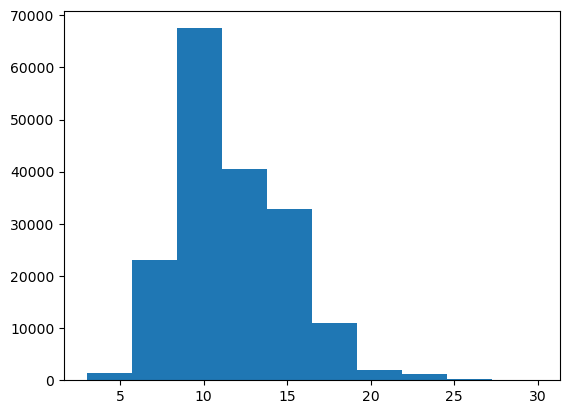

In [128]:
# Check lenght of different lines in training data

plt.hist(train_df['total_lines'])
plt.show()

In [129]:
# Convert text sentences to list

train_sentences=train_df['text'].tolist()
test_sentences=test_df['text'].tolist()
val_sentences=val_df['text'].tolist()

In [130]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

Alright, we've separated our text samples. As you might've guessed, we'll have to write code to convert the text to numbers before we can use it with our machine learning models, we'll get to this soon.

# Making Numeric Labels
We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels (this will enable us to use label smoothing later on).

To numerically encode labels we'll use Scikit-Learn's OneHotEncoder and LabelEncoder classes.

In [131]:
# One hot encoding:

from sklearn.preprocessing import OneHotEncoder
OneHotEncode=OneHotEncoder(sparse=False)

In [132]:
train_labels_one_hot=OneHotEncode.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot=OneHotEncode.transform(test_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot=OneHotEncode.transform(val_df['target'].to_numpy().reshape(-1, 1))

C:\Users\rohan\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [133]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [134]:
tf.constant(train_labels_one_hot)
tf.constant(test_labels_one_hot)
tf.constant(val_labels_one_hot)

<tf.Tensor: shape=(30212, 5), dtype=float64, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [135]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()

In [136]:
train_label_le=LE.fit_transform(train_df['target'].to_numpy())

In [137]:
test_label_le=LE.transform(test_df['target'].to_numpy())
val_label_le=LE.transform(val_df['target'].to_numpy())

In [138]:
train_label_le

array([3, 2, 2, ..., 4, 1, 1])

In [139]:
# Get Class names and number of classes from LabelEncoder

num_classes=len(LE.classes_)
class_names=LE.classes_

print(num_classes,class_names)

5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Creating a series of model experiments
We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in Neural networks for joint sentence classification in medical paper abstracts.

For each model, we'll train it on the training data and evaluate it on the validation data.

# Model_0 Baseline Model

Our first model we'll be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [141]:
#Create Pipeline

model_0=Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

# Fit the Pipeline to training data

model_0.fit(train_sentences,train_label_le)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

Due to the speed of the Multinomial Naive Bayes algorithm, it trains very quickly.

We can evaluate our model's accuracy on the validation dataset using the score() method.

In [142]:
# Evaluate Model_0

model_0.score(val_sentences,val_label_le)

0.7218323844829869

Nice! Looks like 72.1% accuracy will be the number to beat with our deeper models.

Now let's make some predictions with our baseline model to further evaluate it.

In [143]:
test_predictions=model_0.predict(val_sentences)

In [144]:
print(test_predictions[:10])
print(test_label_le[:10])

[4 1 3 2 2 2 2 2 4 4]
[0 4 4 4 4 4 4 1 1 0]


In [145]:
from helper_functions import *

In [146]:
precision_recall_fscore_support(val_label_le,test_predictions)

(array([0.65537383, 0.64606877, 0.72431078, 0.74712644, 0.76200361]),
 array([0.48796753, 0.58642514, 0.87013248, 0.13678451, 0.85794127]),
 array([0.55941499, 0.6148038 , 0.79055348, 0.23123444, 0.80713159]),
 array([3449, 4582, 9964, 2376, 9841], dtype=int64))

In [147]:
model_0_results=calculate_results(val_label_le,test_predictions)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models
We've got a working baseline to try and improve upon.

But before we start building deeper models, we've got to create vectorization and embedding layers.

The vectorization layer will convert our text to numbers and the embedding layer will capture the relationships between those numbers.

To start creating our vectorization and embedding layers, we'll need to import the appropriate libraries (namely TensorFlow and NumPy).

# Model_1 CNN1D

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

Since we'll be turning our sentences into numbers, it's a good idea to figure out how many words are in each sentence.

When our model goes through our sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors).

For example, if one sentence is eight words long and another is 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence.

Let's write some code to find the average length of sentences in the training set.

In [148]:
# How long is each sentence on average?

sentence_length=[len(i.split())for i in train_sentences]
avg_sentence_lenght=[round(sum(len(i.split()) for i in train_sentences)/len(train_sentences))]

In [149]:
print(avg_sentence_lenght,len(sentence_length))

[26] 180040


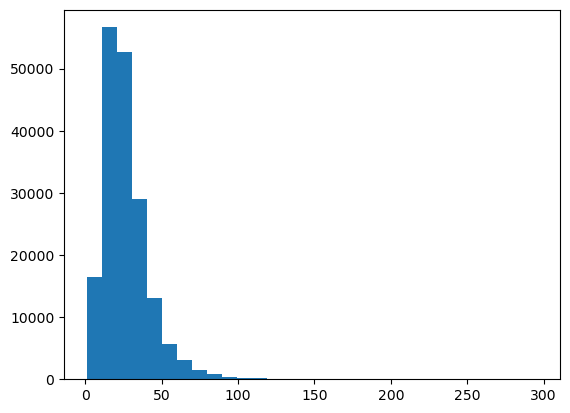

In [150]:
# Check distribution

plt.hist(sentence_length,bins=30)
plt.show()

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's percentile to find the value which covers 95% of the sentence lengths.

In [151]:
# How many words in sentence to cover 95% of sentences
sentence_len_95=np.percentile(sentence_length,95)
sentence_len_95

55.0

Wonderful! It looks like 95% of the sentences in our training set have a length of 55 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated (words after 55 get cut off).

🤔 Question: Why 95%?

We could use the max sentence length of the sentences in the training set.

In [152]:
max_sentence_len=np.max(sentence_length)
max_sentence_len

296

However, since hardly any sentences even come close to the max length, it would mean the majority of the data we pass to our model would be zeros (sinces all sentences below the max length would get padded with zeros).

> 🔑 **Note:** The steps we've gone through are good practice when working with a text corpus for a NLP problem. You want to know how long your samples are and what the distribution of them is. See section 4 Data Analysis of the [PubMed 200k RCT paper](https://arxiv.org/pdf/1710.06071.pdf) for further examples.

### Create text vectorizer
Now we've got a little more information about our texts, let's create a way to turn it into numbers.

To do so, we'll use the TextVectorization layer from TensorFlow.

We'll keep all the parameters default except for max_tokens (the number of unique words in our dataset) and output_sequence_length (our desired output length for each vectorized sentence).

Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [153]:
# Text Vectorization:

vectorize_layer = tf.keras.layers.TextVectorization( max_tokens=68000, #number of words in vocabulary based on PubMed 20k RCT paper,
                                                    
 output_sequence_length=int(sentence_len_95))



In [154]:
# Now that the vocab layer has been created, call `adapt` on the
# text-only dataset to create the vocabulary. You don't have to batch,
# but for large datasets this means we're not keeping spare copies of
# the dataset.

vectorize_layer.adapt(train_sentences)


In [155]:
# Test text vectorizer on random sentences

import random
target_sentence=random.choice(train_sentences)
print(target_sentence)
print(len(target_sentence.split()))
print(vectorize_layer(target_sentence))

collateral status was assessed by consensus using @ different ordinal scales and categorized as good , intermediate , and poor .
21
tf.Tensor(
[11253   272    10   113    22  3226    59   197  5418  1302     3  3575
    25   745  2122     3   716     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)


In [156]:
# How many words in training vocabulary

total_word_count=[sum(len(i.split())for i in train_sentences)]

rct_20k_text_vocab=vectorize_layer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Top 5 Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'5 Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Top 5 Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
5 Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [157]:
# Vectorizer Layer config

vectorize_layer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

# Create Text Embedding Layer

In [158]:
token_embed=tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), output_dim=128,mask_zero=True, name='TokenEmbedding')



In [159]:
print(f'Original Sentence:\n{target_sentence}\n')
print(f'Vectorized Sentence:\n{vectorize_layer([target_sentence])}\n')
print(f'Embeded Sentence: {token_embed(vectorize_layer([target_sentence]))}')
vectorized_sentence=vectorize_layer([target_sentence])

Original Sentence:
collateral status was assessed by consensus using @ different ordinal scales and categorized as good , intermediate , and poor .

Vectorized Sentence:
[[11253   272    10   113    22  3226    59   197  5418  1302     3  3575
     25   745  2122     3   716     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embeded Sentence: [[[ 0.00530497 -0.02557905  0.00183011 ...  0.0410596  -0.0022319
   -0.03103715]
  [-0.00440609 -0.00476979  0.02859446 ... -0.00343706 -0.01801612
   -0.00973115]
  [ 0.00747592 -0.02228429  0.02054094 ... -0.01956107  0.00395668
   -0.03875569]
  ...
  [-0.03735147  0.005271    0.00761914 ... -0.00355965  0.0429746
   -0.00632878]
  [-0.03735147  0.005271    0.00761914 ... -0.00355965  0.0429746
   -0.00632878]
  [-0.03735147  0.005271    0.00761914 ... -0.00355

In [160]:
vectorized_sentence1=vectorize_layer([target_sentence])
print(vectorized_sentence1.shape)
embeded_sentence=token_embed(vectorized_sentence1)
print(embeded_sentence.shape)

(1, 55)
(1, 55, 128)


## Create datasets (as fast as possible)

We've gone through all the trouble of preprocessing our datasets to be used with a machine learning model, however, there are still a few steps we can use to make them work faster with our models.

Namely, the `tf.data` API provides methods which enable faster data loading.

> 📖 **Resource:** For best practices on data loading in TensorFlow, check out the following:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

# Creating Datasets

In [161]:
# Turn our data into Tesnorflow Datasets

train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))

train_dataset


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [162]:
# Turn the TensorSliceDataset into prefetched datasets

train_dataset_prefetched=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_prefetched=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_prefetched=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_prefetched

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model_1 CNN1D

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

The first model we're going to build is a 1-dimensional Convolutional Neural Network.

We're also going to be following the standard machine learning workflow of:

Build model
Train model
Evaluate model (make predictions and compare to ground truth)

In [163]:
from tensorflow.keras import layers

inputs=layers.Input(shape=(1,),dtype='string')
x=vectorize_layer(inputs)
x=token_embed(x)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(x)
print(x.shape)
x=layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs=layers.Dense(num_classes,activation='softmax')(x)
print(outputs.shape)
model_1=tf.keras.Model(inputs,outputs,name='CNN1D_Model1')

# Compile Model1

model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics='accuracy')


                                

(None, 55, 64)
(None, 64)
(None, 5)


In [164]:
model_1.summary()

Model: "CNN1D_Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 TokenEmbedding (Embedding)  (None, 55, 128)           8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_11 (Dense)            (None, 5)                

Wonderful! We've got our first deep sequence model built and ready to go.

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the output_dim parameter of the Embedding layer), the number of trainable parameters would increase dramatically.

It's time to fit our model to the training data but we're going to make a mindful change.

Since our training data contains nearly 200,000 sentences, fitting a deep model may take a while even with a GPU. So to keep our experiments swift, we're going to run them on a subset of the training dataset.

More specifically, we'll only use the first 10% of batches (about 18,000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

🔑 Note: It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

In [165]:
# Fit the model
model_1_history = model_1.fit(train_dataset_prefetched,
                              steps_per_epoch=int(0.1 * len(train_dataset_prefetched)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset_prefetched,
                              validation_steps=int(0.1 * len(val_dataset_prefetched))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 48s 83ms/step - loss: 0.9184 - accuracy: 0.6370 - val_loss: 0.6889 - val_accuracy: 0.7360
Epoch 2/3
562/562 [==============================] - 46s 82ms/step - loss: 0.6572 - accuracy: 0.7581 - val_loss: 0.6362 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 46s 82ms/step - loss: 0.6155 - accuracy: 0.7759 - val_loss: 0.5959 - val_accuracy: 0.7836


In [166]:
# Evaluate Model_1
val_predict=model_1.predict(val_dataset_prefetched)
model_1.evaluate(val_dataset_prefetched)
val_predict[:3]

945/945 [==============================] - 6s 6ms/step - loss: 0.5967 - accuracy: 0.7875


array([[4.5540801e-01, 1.7661425e-01, 4.5456082e-02, 3.0381075e-01,
        1.8710928e-02],
       [4.1420224e-01, 3.1983495e-01, 1.1592747e-02, 2.4480748e-01,
        9.5625343e-03],
       [1.4542350e-01, 5.7542594e-03, 1.6706067e-03, 8.4713197e-01,
        1.9739853e-05]], dtype=float32)

In [167]:
# Convert pred probs to classes
model_1_preds = tf.argmax(val_predict, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [168]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_label_le,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.75016549715345,
 'precision': 0.7848330891527547,
 'recall': 0.7875016549715345,
 'f1': 0.7855305376465076}

In [169]:
# Calculate model_0 results
model_0_results = calculate_results(y_true=val_label_le,
                                    y_pred=test_predictions)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [170]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(val_label_le,model_1_preds)

In [171]:
print(val_label_le[:10])
print(val_labels_one_hot[:10])
print(model_1_preds)

val_predict=model_1.predict(val_sentences)
val_predict[:5]

[0 0 3 2 2 4 4 4 4 1]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
tf.Tensor([0 0 3 ... 4 1 1], shape=(30212,), dtype=int64)
945/945 [==============================] - 6s 6ms/step


array([[4.5540801e-01, 1.7661425e-01, 4.5456082e-02, 3.0381075e-01,
        1.8710928e-02],
       [4.1420224e-01, 3.1983495e-01, 1.1592747e-02, 2.4480748e-01,
        9.5625343e-03],
       [1.4542350e-01, 5.7542594e-03, 1.6706067e-03, 8.4713197e-01,
        1.9739853e-05],
       [1.4951445e-05, 3.9211215e-04, 9.8021036e-01, 1.7406568e-05,
        1.9365085e-02],
       [9.3818898e-04, 3.9248511e-02, 2.7169237e-01, 8.5765065e-04,
        6.8726331e-01]], dtype=float32)

In [172]:
cm

array([[1817,  649,  255,  685,   43],
       [ 422, 3297,  168,  119,  576],
       [ 113,  152, 8710,  144,  845],
       [ 500,  248,  172, 1432,   24],
       [  31,  486,  777,   11, 8536]], dtype=int64)

# Model 2: Feature extraction with pretrained token embeddings

Training our own embeddings took a little while to run, slowing our experiments down.

Since we're moving towards replicating the model architecture in [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf), it mentions they used a [pretrained GloVe embedding](https://nlp.stanford.edu/projects/glove/) as a way to initialise their token embeddings.

To emulate this, let's see what results we can get with the [pretrained Universal Sentence Encoder embeddings from TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4).

> 🔑 **Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

You'll notice the lack of tokenization layer we've used in a previous model. This is because the Universal Sentence Encoder (USE) takes care of tokenization for us.

This type of model is called transfer learning, or more specifically, **feature extraction transfer learning**. In other words, taking the patterns a model has learned elsewhere and applying it to our own problem.

![TensorFlow Hub Universal Feature Encoder feature extractor model we're building](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-model-tf-hub-USE-to-dense-layer.png)
*The feature extractor model we're building using a pretrained embedding from TensorFlow Hub.*

To download the pretrained USE into a layer we can use in our model, we can use the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

> 🔑 **Note:** Due to having to download a relatively large model (~916MB), the cell below may take a little while to run.

In [176]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
  


In [180]:
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     input_shape=[],trainable= False,                                
                                     dtype=tf.string,name='USE')

save_dir='model_logs'

In [181]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = sentence_encoder_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the placement torques were @ and @ n cm in the self-tapping and self-drilling miniscrews , respectively ( p > @ ) .

Sentence after embedding:
[ 0.0422915  -0.05336276  0.01796304 -0.00458371  0.0759514   0.00229376
 -0.00724004  0.01077841 -0.09180538 -0.00359411 -0.01060849 -0.000168
 -0.02042739  0.06077369  0.03635165 -0.00742928 -0.00108531 -0.01838656
  0.07195111 -0.00053476  0.058935    0.01395775 -0.00104701 -0.0759764
 -0.00845619  0.02604401  0.03059044 -0.02438454  0.0156774   0.0468303 ] (truncated output)...

Length of sentence embedding:
512


In [182]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = sentence_encoder_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs, name='Model_2_FeatureExtractor')

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [183]:
# Get a summary of the model
model_2.summary()

Model: "Model_2_FeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [184]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset_prefetched,
            steps_per_epoch=int(0.1 * len(train_dataset_prefetched)),
            epochs=3,
            validation_data=val_dataset_prefetched,
            validation_steps=int(0.1 * len(val_dataset_prefetched)))

Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9162 - accuracy: 0.6507 - val_loss: 0.7973 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7688 - accuracy: 0.7020 - val_loss: 0.7560 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7527 - accuracy: 0.7125 - val_loss: 0.7401 - val_accuracy: 0.7091


In [185]:
model_2.evaluate(val_dataset_prefetched)

945/945 [==============================] - 14s 14ms/step - loss: 0.7420 - accuracy: 0.7124


[0.742018461227417, 0.7123990654945374]

In [186]:
val_predict2=model_2.predict(val_dataset_prefetched)

945/945 [==============================] - 14s 14ms/step


In [187]:
model2_prob=tf.argmax(val_predict2,axis=1)

In [188]:
model_2_results=calculate_results(val_label_le,model2_prob)
model_2_results

{'accuracy': 71.23990467363961,
 'precision': 0.7125562036525854,
 'recall': 0.7123990467363961,
 'f1': 0.7093023029519061}

### Creating a character-level tokenizer

The [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf) paper mentions their model uses a hybrid of token and character embeddings.

We've built models with a custom token embedding and a pretrained token embedding, how about we build one using a character embedding?

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. `hello` -> [`h`, `e`, `l`, `l`, `o`]) where as a **token embedding** is created on sequences split into tokens.

![example of difference between token level and character level embeddings](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-token-vs-character-embeddings.png)
*Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.*

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class and then passing those vectorized sequences through an [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

In [189]:
# Creating Character Level Tokenizer

# Make a function to split sentences into characters

def get_characters(sentences):
    return " ".join(list(sentences))


        

In [190]:
# Split training, test and Val sentences into characters

train_chars=[get_characters(sentence) for sentence in train_sentences]
test_chars=[get_characters(sentence) for sentence in test_sentences]
val_chars=[get_characters(sentence) for sentence in val_sentences]
len(train_chars)

180040

In [191]:
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [192]:
# What's the avg character length:
total_char=[len(i) for i in train_sentences]
avg_chars_train=np.mean([len(i) for i in train_sentences])
avg_chars_train

149.3662574983337

In [193]:
# Check the distribution of sequence at character level

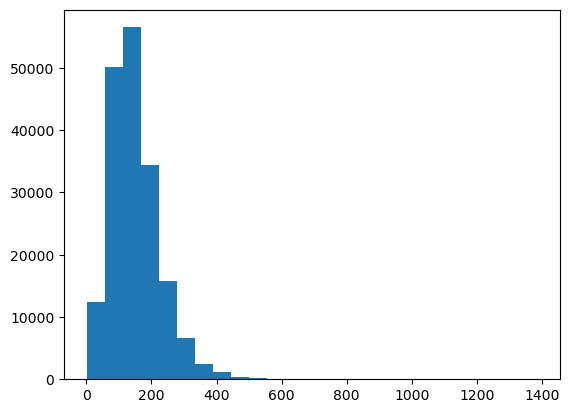

In [194]:
plt.hist(total_char, bins=25)
plt.show()

In [195]:
# How many characters in sentence to cover 95%
char_len_95=np.percentile(total_char,95)
char_len_95

290.0

In [196]:
# Get all keyboard characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
len(alphabet)

68

In [197]:
# Create Char Level Token Vectorizer Instance

Num_Char_Tokens=len(alphabet)+2

char_vectorizer=tf.keras.layers.TextVectorization(max_tokens=Num_Char_Tokens,output_sequence_length=int(char_len_95),
                                                  name='char_vectorizer')

In [198]:
# Adapt character vectorizer to training characters

char_vectorizer.adapt(train_chars)

In [199]:
# Check character vocab stats

char_vocab=char_vectorizer.get_vocabulary()
print(f'Number of different character in character vocab: {len(char_vocab)}')
print(f'Top 5 most common characters: {char_vocab[:5]}')
print(f'Least 5 most common characters: {char_vocab[-5:]}')

Number of different character in character vocab: 28
Top 5 most common characters: ['', '[UNK]', 'e', 't', 'i']
Least 5 most common characters: ['k', 'x', 'z', 'q', 'j']


In [200]:
# Test character vectorizer on random sentences

import random
target_sentence=random.choice(train_sentences)
print(target_sentence)
print(len(target_sentence))
print(char_vectorizer(get_characters(target_sentence)))

leuprorelin acetate maybe better tolerated than triptorelin .
61
tf.Tensor(
[12  2 16 14  8  7  8  2 12  4  6  5 11  2  3  5  3  2 15  5 19 22  2 22
  2  3  3  2  8  3  7 12  2  8  5  3  2 10  3 13  5  6  3  8  4 14  3  7
  8  2 12  4  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(290,), dtype=int64)


# Creating a Character Level Embedding



In [201]:
char_token_embed=tf.keras.layers.Embedding(input_dim=len(char_vocab), output_dim=25,mask_zero=True, name='CharacterEmbedding')



In [202]:

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{get_characters(target_sentence)}\n")
char_embed_example = char_token_embed(char_vectorizer([get_characters(target_sentence)]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
l e u p r o r e l i n   a c e t a t e   m a y b e   b e t t e r   t o l e r a t e d   t h a n   t r i p t o r e l i n   .

Embedded chars (after vectorization and embedding):
[[[ 0.02447924  0.02143805 -0.03193473 ... -0.0261915   0.00387025
    0.02430831]
  [ 0.00257819 -0.0292776   0.00938132 ...  0.01697227 -0.02644728
   -0.04523705]
  [-0.01858395  0.03153424 -0.01332065 ... -0.03799021 -0.00589412
    0.0289142 ]
  ...
  [-0.01043333  0.04728669 -0.04185273 ... -0.04171085  0.00044993
   -0.02209498]
  [-0.01043333  0.04728669 -0.04185273 ... -0.04171085  0.00044993
   -0.02209498]
  [-0.01043333  0.04728669 -0.04185273 ... -0.04171085  0.00044993
   -0.02209498]]]

Character embedding shape: (1, 290, 25)


In [203]:
# Create chare level datasets:

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

# Model_3 Character Level Embedding CNN1D



In [204]:
from tensorflow.keras import layers

inputs=layers.Input(shape=(1,),dtype='string')
x=char_vectorizer(inputs)
x=char_token_embed(x)
x=layers.Conv1D(64,kernel_size=3,padding='same',activation='relu')(x)
print(x.shape)
x=layers.GlobalMaxPooling1D()(x)
print(x.shape)
outputs=layers.Dense(num_classes,activation='softmax')(x)
print(outputs.shape)
model_3=tf.keras.Model(inputs,outputs,name='CNN1D_Model3')

# Compile Model5

model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics='accuracy')


                                

(None, 290, 64)
(None, 64)
(None, 5)


In [205]:
model_3.summary()

Model: "CNN1D_Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 CharacterEmbedding (Embedd  (None, 290, 25)           700       
 ing)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           4864      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                      

In [206]:
# Fit Model 3
model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=3,
            validation_data=val_char_dataset,
            validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 14ms/step - loss: 1.3677 - accuracy: 0.4465 - val_loss: 1.1708 - val_accuracy: 0.5432
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 1.1031 - accuracy: 0.5532 - val_loss: 1.0284 - val_accuracy: 0.5908
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 1.0257 - accuracy: 0.5877 - val_loss: 0.9680 - val_accuracy: 0.6077


In [207]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.9851 - accuracy: 0.6094


[0.9851462244987488, 0.609426736831665]

In [208]:
model_3_pred=model_3.predict(val_char_dataset)

945/945 [==============================] - 7s 8ms/step


In [209]:
model_3_pred=np.argmax(model_3_pred,axis=1)
model_3_pred

array([3, 1, 3, ..., 4, 2, 0], dtype=int64)

In [210]:
model_3_results=calculate_results(val_label_le,model_3_pred)
model_3_results

{'accuracy': 60.942671786045274,
 'precision': 0.6023438553406233,
 'recall': 0.6094267178604528,
 'f1': 0.5948165146347589}

# Model 4 Combining pretrained token embedding + character embedding 

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token level embedding model
2. Create a character level embedding model
3. Concatenate both models
4. Build a series of output layers
5. Construct a model with take token and character level sequences as inputs 

In [211]:
# Setup token inputs/model

token_inputs=tf.keras.layers.Input(shape=[],dtype='string')
token_embedding=sentence_encoder_layer(token_inputs)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_embedding)
token_model=tf.keras.Model(token_inputs,token_outputs)

# Setup character level embedded model

char_inputs=tf.keras.layers.Input(shape=[],dtype='string')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_token_embed(char_vectors)
char_bi_lstm=tf.keras.layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

# Concatenate token and char embedded models

token_char_concat=tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output,char_model.output])

# Create output layer

combined_dropout=tf.keras.layers.Dropout(.5)(token_char_concat)
combined_dense=tf.keras.layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=tf.keras.layers.Dropout(.5)(combined_dense)
output_layer=tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)


# Construct Models with char and token inputs

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer,name='Model4_Token_Char_HybridModel')

In [212]:
# Fit Model_4

model_4.summary()

Model: "Model4_Token_Char_HybridModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_10[0][0]']            
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  2567978   ['

In [213]:
from keras.utils import plot_model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [214]:
import graphviz

In [215]:
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [216]:
# Compile Model_4

model_4.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer='Adam',
               metrics='Accuracy')

# Prefetching Datasets for fast processing

In [217]:
# Combine chars and tokens into a dataset:


train_token_char_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset=tf.data.Dataset.zip((train_token_char_data,train_token_char_labels))

test_token_char_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_token_char_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_token_char_dataset=tf.data.Dataset.zip((test_token_char_data,test_token_char_labels))

val_token_char_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset=tf.data.Dataset.zip((val_token_char_data,val_token_char_labels))


In [218]:
# Prefetch and batch datasets:

train_token_char_dataset=train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_char_dataset=test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset=val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [219]:
# Fit the model_4

history_model_4=model_4.fit(train_token_char_dataset,steps_per_epoch=int(.1*len(train_token_char_dataset)), epochs=3,validation_data=val_token_char_dataset,
                            validation_steps=int(.1*len(val_token_char_dataset))
                            )

Epoch 1/3
562/562 [==============================] - 78s 124ms/step - loss: 0.9758 - Accuracy: 0.6124 - val_loss: 0.7730 - val_Accuracy: 0.7031
Epoch 2/3
562/562 [==============================] - 69s 123ms/step - loss: 0.8003 - Accuracy: 0.6901 - val_loss: 0.7192 - val_Accuracy: 0.7324
Epoch 3/3
562/562 [==============================] - 72s 128ms/step - loss: 0.7739 - Accuracy: 0.7051 - val_loss: 0.6934 - val_Accuracy: 0.7367


In [220]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 35s 37ms/step - loss: 0.6970 - Accuracy: 0.7352


[0.6969851851463318, 0.7352045774459839]

In [221]:
pred_4=model_4.predict(val_token_char_dataset)


945/945 [==============================] - 44s 42ms/step


In [222]:
model4_preds=tf.argmax(pred_4,axis=1)
print(model4_preds[:5])
model_4_results=calculate_results(val_label_le,model4_preds)
model_4_results

tf.Tensor([0 1 3 2 2], shape=(5,), dtype=int64)


{'accuracy': 73.52045544816629,
 'precision': 0.7355847893360452,
 'recall': 0.7352045544816629,
 'f1': 0.733638908373125}

# Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings 

It seems like combining token embeddings and character embeddings gave our model a little performance boost.

But there's one more piece of the puzzle we can add in.

What if we engineered our own features into the model?

Meaning, what if we took our own knowledge about the data and encoded it in a numerical way to give our model more information about our samples?

The process of applying your own knowledge to build features as input to a model is called **feature engineering**.

Can you think of something important about the sequences we're trying to classify?

If you were to look at an abstract, would you expect the sentences to appear in order? Or does it make sense if they were to appear sequentially? For example, sequences labelled `CONCLUSIONS` at the beggining and sequences labelled `OBJECTIVE` at the end?

Abstracts typically come in a sequential order, such as:
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...

Or

* `BACKGROUND` ...
* `OBJECTIVE` ...
* `METHODS` ...
* `METHODS` ...
* `RESULTS` ...
* `RESULTS` ...
* `CONCLUSIONS` ...
* `CONCLUSIONS` ...

Of course, we can't engineer the sequence labels themselves into the training data (we don't have these at test time), but we can encode the order of a set of sequences in an abstract.

For example,
* `Sentence 1 of 10` ...
* `Sentence 2 of 10` ...
* `Sentence 3 of 10` ...
* `Sentence 4 of 10` ...
* ...


You might've noticed this when we created our `preprocess_text_with_line_numbers()` function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the `"line_number"` and `"total_lines"` columns of our DataFrames.

In [223]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


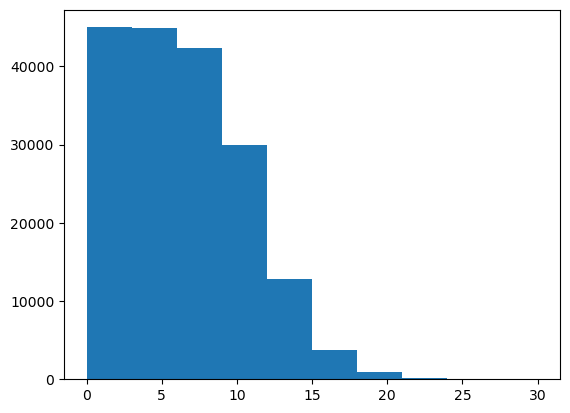

In [224]:
plt.hist(train_df['line_number'],bins=10)
plt.show()

In [225]:
# Create One-hot-encoded Line_Numbers

train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

train_line_numbers_one_hot[20:29]

<tf.Tensor: shape=(9, 15), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

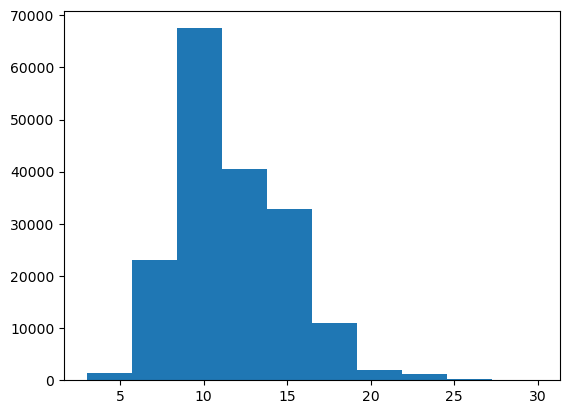

In [226]:
plt.hist(train_df['total_lines'])
plt.show()

In [227]:
# How many lines cover 95% of total lines

np.percentile(train_df['total_lines'],95)

18.0

In [228]:
train_df['total_lines'].max()

30

In [229]:
train_df['total_lines'][:10]

0    11
1    11
2    11
3    11
4    11
5    11
6    11
7    11
8    11
9    11
Name: total_lines, dtype: int64

In [230]:
# Create One-hot-encoding for Total_lines

train_total_lines_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

train_total_lines_one_hot[10:20]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
     

In [231]:
# Building Tribrid Model
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Token Inputs
token_inputs=tf.keras.Input(shape=[],dtype='string',name='token_inputs')
token_embeddings=sentence_encoder_layer(token_inputs)
token_outputs=tf.keras.layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,outputs=token_outputs)

# Char Inputs
char_inputs=tf.keras.Input(shape=(1,),dtype='string',name='char_inputs')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_token_embed(char_vectors)
char_bi_lstm=tf.keras.layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

# Line_Number Inputs
line_number_inputs=tf.keras.Input(shape=(15,),dtype=tf.float32,name='Line_number_inputs')
line_number_outputs=tf.keras.layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,line_number_outputs)

# Total_Lines Input
total_lines_inputs=tf.keras.Input(shape=(20,),dtype=tf.float32,name='Total_lines_input')
total_lines_outpus=tf.keras.layers.Dense(32,activation='relu')(total_lines_inputs)
total_line_model=tf.keras.Model(total_lines_inputs,total_lines_outpus)


# Combine token and Char Embeddings into a hybrid embeddings
token_char_combine=tf.keras.layers.Concatenate(name='token_char_combine')([token_model.output,char_model.output])


z=tf.keras.layers.Dense(32,activation='relu')(token_char_combine)
z=tf.keras.layers.Dropout(.5)(z)


# Combine positional embedding with token and char embeddings
trybrid_embeddings=tf.keras.layers.Concatenate(name='positional_token_char_combine')([line_number_model.output,
                                                                                  total_line_model.output,z])

# Create output layer
output_layer=tf.keras.layers.Dense(len(class_names),activation='softmax',name='Output_layer')(trybrid_embeddings)

# Create Model
model_5=tf.keras.Model(inputs=[token_model.input,char_model.input,line_number_model.input,total_line_model.input],outputs=output_layer,
                      name='positional_token_char_embedded_model')

In [232]:
model_5.summary()

Model: "positional_token_char_embedded_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 USE (KerasLayer)            (None, 512)                  25679

In [236]:
plot_model(model_5)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [237]:
# Compile Model_5

model_5.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer='Adam',
               metrics='Accuracy')

In [238]:
# Creating Dataset with tokens, chars, line_number and total_lines data


train_token_char_line_no_total_lines_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars,train_line_numbers_one_hot,train_total_lines_one_hot))
train_token_char_line_no_total_lines_dataset=tf.data.Dataset.zip((train_token_char_line_no_total_lines_data,train_token_char_labels))

val_token_char_line_no_total_lines_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars,val_line_numbers_one_hot,val_total_lines_one_hot))
val_token_char_line_no_total_lines_dataset=tf.data.Dataset.zip((val_token_char_line_no_total_lines_data,val_token_char_labels))


test_token_char_line_no_total_lines_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars,test_line_numbers_one_hot,test_total_lines_one_hot))
test_token_char_line_no_total_lines_dataset=tf.data.Dataset.zip((test_token_char_line_no_total_lines_data,test_token_char_labels))

In [239]:
# Prefetch and batch datasets:

train_token_char_line_no_total_lines_dataset=train_token_char_line_no_total_lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_char_line_no_total_lines_dataset=test_token_char_line_no_total_lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_line_no_total_lines_dataset=val_token_char_line_no_total_lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [240]:
train_token_char_line_no_total_lines_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [241]:
# Fitting Model_5

history_model_5=model_5.fit(train_token_char_line_no_total_lines_dataset,epochs=3,steps_per_epoch=int(.1*len(train_token_char_line_no_total_lines_dataset)),
                           validation_data=val_token_char_line_no_total_lines_dataset,
                           validation_steps=int(.1*len(val_token_char_line_no_total_lines_dataset)))

Epoch 1/3
562/562 [==============================] - 259s 446ms/step - loss: 0.8435 - Accuracy: 0.6768 - val_loss: 0.5647 - val_Accuracy: 0.7902
Epoch 2/3
562/562 [==============================] - 701s 1s/step - loss: 0.5607 - Accuracy: 0.7855 - val_loss: 0.4871 - val_Accuracy: 0.8198
Epoch 3/3
562/562 [==============================] - 216s 384ms/step - loss: 0.5137 - Accuracy: 0.8014 - val_loss: 0.4618 - val_Accuracy: 0.8215


In [242]:
model_5.evaluate(val_token_char_line_no_total_lines_dataset)

945/945 [==============================] - 118s 124ms/step - loss: 0.4583 - Accuracy: 0.8184


[0.45830556750297546, 0.8183503150939941]

In [243]:
model5_preds=model_5.predict(val_token_char_line_no_total_lines_dataset)
model5_preds=tf.argmax(model5_preds,axis=1)



945/945 [==============================] - 121s 123ms/step


In [244]:
model_5_results=calculate_results(val_label_le,model5_preds)
model_5_results

{'accuracy': 81.83503243744208,
 'precision': 0.8184382239843909,
 'recall': 0.8183503243744208,
 'f1': 0.8178095035607814}

# Compare all model results

In [245]:
all_model_results=pd.DataFrame({'model_0_baseline':model_0_results, 'model_1_custom_token_embedding':model_1_results,
                                'model_2_pretrained_token_embedding':model_2_results,
                               'model_3_custom_char_embedding':model_3_results,'model_4_token+char_embedding':model_4_results,
                               'model_4_pretrained_token_custom_char_feature_engg': model_5_results})

all_model_results=all_model_results.T
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.750165,0.784833,0.787502,0.785531
model_2_pretrained_token_embedding,71.239905,0.712556,0.712399,0.709302
model_3_custom_char_embedding,60.942672,0.602344,0.609427,0.594817
model_4_token+char_embedding,73.520455,0.735585,0.735205,0.733639
model_4_pretrained_token_custom_char_feature_engg,81.835032,0.818438,0.818350,0.817810


In [246]:
all_model_results['accuracy']=all_model_results['accuracy']/100

all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.787502,0.784833,0.787502,0.785531
model_2_pretrained_token_embedding,0.712399,0.712556,0.712399,0.709302
model_3_custom_char_embedding,0.609427,0.602344,0.609427,0.594817
model_4_token+char_embedding,0.735205,0.735585,0.735205,0.733639
model_4_pretrained_token_custom_char_feature_engg,0.818350,0.818438,0.818350,0.817810


<Figure size 1000x500 with 0 Axes>

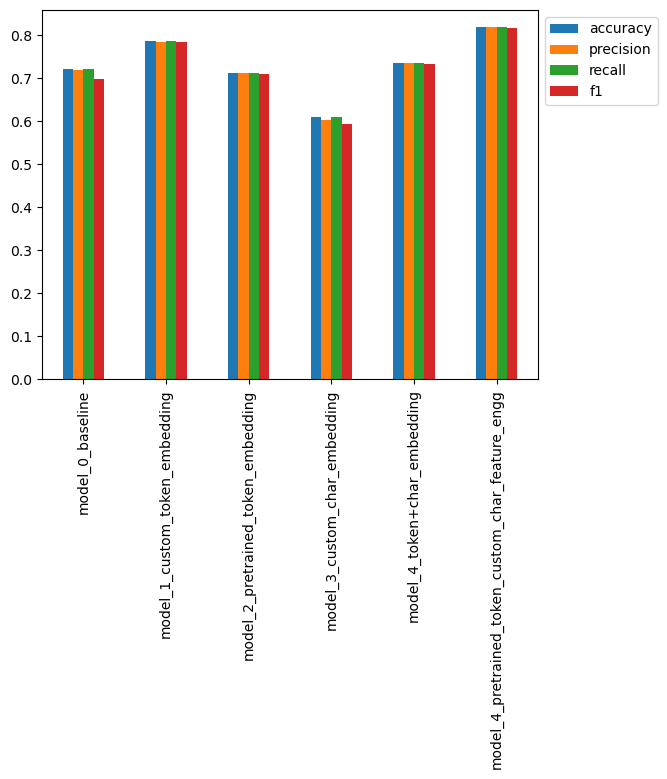

In [247]:
# Plot and compare all models:
fig = plt.figure(figsize = (10, 5));

all_model_results.plot(kind='bar').legend(bbox_to_anchor=(1,1));
#plt.show();

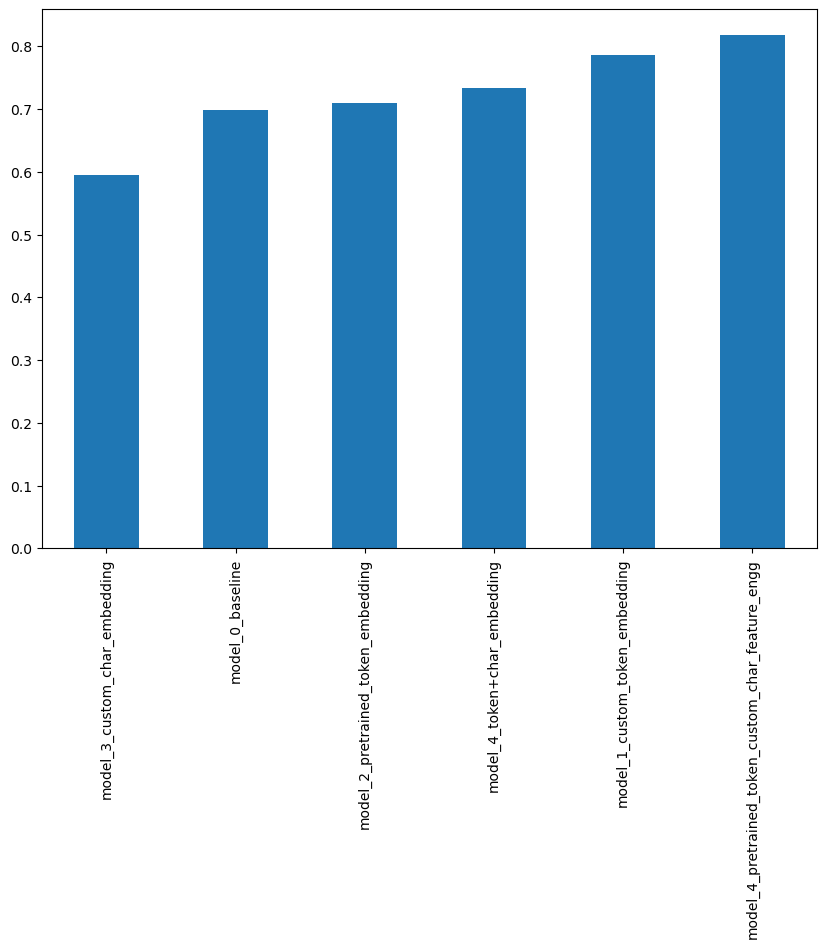

In [248]:
# Sort model results by F1-Score

all_model_results.sort_values('f1',ascending=True)['f1'].plot(kind='bar',figsize=(10,7));

# Model_6 Custom Token+ Char + Positional Embedding

In [249]:
# Building Tribrid Model


# Token Inputs
#inputs=layers.Input(shape=(1,),dtype='string')
#x=vectorize_layer(inputs)
#x=token_embed(x)
#token_outputs=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(x)
#x=layers.GlobalAveragePooling1D()(x)
#token_outputs=layers.Dense(128,activation='relu')(x)
#token_model1=tf.keras.Model(inputs,token_outputs,name='CNN1D_Model1')


inputs=layers.Input(shape=(1,),dtype='string')
x=vectorize_layer(inputs)
x=token_embed(x)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(x)
print(x.shape)
x=layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs=layers.Dense(128,activation='relu')(x)
print(outputs.shape)
model_1=tf.keras.Model(inputs,outputs,name='CNN1D_Model1')






# Char Inputs
char_inputs=tf.keras.Input(shape=(1,),dtype='string',name='char_inputs')
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_token_embed(char_vectors)
char_bi_lstm=tf.keras.layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

# Line_Number Inputs
line_number_inputs=tf.keras.Input(shape=(15,),dtype=tf.float32,name='Line_number_inputs')
line_number_outputs=tf.keras.layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,line_number_outputs)

# Total_Lines Input
total_lines_inputs=tf.keras.Input(shape=(20,),dtype=tf.float32,name='Total_lines_input')
total_lines_outpus=tf.keras.layers.Dense(32,activation='relu')(total_lines_inputs)
total_line_model=tf.keras.Model(total_lines_inputs,total_lines_outpus)


# Combine token and Char Embeddings into a hybrid embeddings
token_char_combine=tf.keras.layers.Concatenate(name='token_char_combine')([model_1.output,char_model.output])


z=tf.keras.layers.Dense(32,activation='relu')(token_char_combine)
z=tf.keras.layers.Dropout(.5)(z)


# Combine positional embedding with token and char embeddings
trybrid_embeddings=tf.keras.layers.Concatenate(name='positional_token_char_combine')([line_number_model.output,
                                                                                  total_line_model.output,z])

# Create output layer
output_layer=tf.keras.layers.Dense(len(class_names),activation='softmax',name='Output_layer')(trybrid_embeddings)

# Create Model
model_6=tf.keras.Model(inputs=[model_1.input,char_model.input,line_number_model.input,total_line_model.input],outputs=output_layer,
                      name='positional_token_embedded_model6')

(None, 55, 64)
(None, 64)
(None, 128)


In [250]:
# Compile Model_6

model_6.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer='Adam',
               metrics='Accuracy')

In [251]:
# Creating Dataset with tokens, chars, line_number and total_lines data


train_CNN_char_line_no_total_lines_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars,train_line_numbers_one_hot,train_total_lines_one_hot))
train_CNN_char_line_no_total_lines_dataset=tf.data.Dataset.zip((train_CNN_char_line_no_total_lines_data,train_token_char_labels))

val_CNN_char_line_no_total_lines_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars,val_line_numbers_one_hot,val_total_lines_one_hot))
val_CNN_char_line_no_total_lines_dataset=tf.data.Dataset.zip((val_CNN_char_line_no_total_lines_data,val_token_char_labels))

# Prefetch and batch datasets:

train_CNN_char_line_no_total_lines_dataset=train_CNN_char_line_no_total_lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_CNN_char_line_no_total_lines_dataset=val_CNN_char_line_no_total_lines_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [252]:
# Fitting Model_6

history_model_6=model_6.fit(train_CNN_char_line_no_total_lines_dataset,epochs=3,steps_per_epoch=int(.1*len(train_CNN_char_line_no_total_lines_dataset)),
                           validation_data=val_CNN_char_line_no_total_lines_dataset,
                           validation_steps=int(.1*len(val_CNN_char_line_no_total_lines_dataset)))

Epoch 1/3
562/562 [==============================] - 177s 289ms/step - loss: 0.6596 - Accuracy: 0.7585 - val_loss: 0.5001 - val_Accuracy: 0.8122
Epoch 2/3
562/562 [==============================] - 163s 290ms/step - loss: 0.4298 - Accuracy: 0.8425 - val_loss: 0.4450 - val_Accuracy: 0.8251
Epoch 3/3
562/562 [==============================] - 162s 289ms/step - loss: 0.3892 - Accuracy: 0.8559 - val_loss: 0.4134 - val_Accuracy: 0.8358
